In [1]:

from pkg_resources import resource_filename
import os

import numpy as np
import pandas as pd


from digicampipe.instrument import geometry
from digicampipe.io.event_stream import event_stream, add_slow_data


from cts_core.camera import Camera
from ctapipe.visualization import CameraDisplay
# from ctapipe.instrument import CameraGeometry
from ctapipe.image import hillas_parameters, tailcuts_clean
from ctapipe.image.cleaning import dilate, number_of_islands, fact_image_cleaning

import matplotlib.pyplot as plt
#import datetime

#from scipy.optimize import curve_fit
#from scipy.ndimage import convolve1d

import astropy.units as u

In [2]:
digicam_config_file = resource_filename('digicampipe','tests/resources/camera_config.cfg')
digicam = Camera(_config_file=digicam_config_file)
geom = geometry.generate_geometry_from_camera(camera=digicam)
geom.pix_area = np.ones(geom.n_pixels)*482.05

In [3]:
files = ['/net/cs2/data/raw/2022/11/14/SST1M2/SST1M2_20221114_0159.fits.fz']

In [4]:
##maxev 149 401

In [5]:
data_stream = event_stream(filelist   = files,
                           max_events = 3000,
                           disable_bar = True
                           )


In [6]:
# take a look at the event with id 2805 (it has a nice shower)
EVENT = 2805

for event in data_stream:
    if event.r0.event_id == EVENT:
        break
        
event.r0.event_id

2805

In [7]:
event

digicampipe.io.containers.DataContainer:
                          r0.*: Raw Data
                          r1.*: Raw Common Data
                         dl0.*: DL0 Data Volume Reduced Data
                         dl1.*: DL1 Calibrated image
                         dl2.*: Reconstructed Shower Information
                          mc.*: Monte-Carlo data
                    mcheader.*: Monte-Carlo run header data
                        inst.*: Instrumental information
                     slow_data: Slow Data Information
                        trig.*: central trigger information
                         count: number of events processed

In [8]:
event.r0

digicampipe.io.containers.R0Container:
                        run_id: run id number
                      event_id: event id number
                tels_with_data: list of telescopes with data
                        tel[*]: map of tel_id to R0CameraContainer

In [9]:
event.r0.tels_with_data

[22]

In [10]:
event.r0.tel[22]

digicampipe.io.containers.R0CameraContainer:
                   pixel_flags: numpy array containing pixel flags
                   adc_samples: numpy array containing ADC samples(n_channels x
                                n_pixels, n_samples)
                      adc_sums: numpy array containing integrated ADC
                                data(n_channels, x n_pixels)
                      baseline: number of time samples for telescope
              digicam_baseline: Baseline computed by DigiCam
            standard_deviation: number of time samples for telescope
                 dark_baseline: dark baseline
               hv_off_baseline: HV off baseline
               camera_event_id: Camera event number
           camera_event_number: camera event number
            local_camera_clock: camera timestamp
                      gps_time: gps timestamp
             white_rabbit_time: precise white rabbit based timestamp
            _camera_event_type: camera event type
             

In [11]:
r0data = event.r0.tel[event.r0.tels_with_data[0]]

In [12]:
PIXEL_ID = 730 ## this pixel have some signal

In [13]:
r0data.adc_samples[PIXEL_ID]

array([231, 226, 223, 217, 215, 211, 210, 213, 217, 225, 251, 302, 334,
       333, 308, 274, 251, 238, 232, 228, 225, 220, 226, 228, 228, 226,
       222, 221, 224, 226, 224, 222, 218, 216, 218, 224, 237, 242, 243,
       238, 232, 224, 224, 224, 231, 232, 232, 230, 229, 231], dtype=int16)

Text(0, 0.5, 'ADC count')

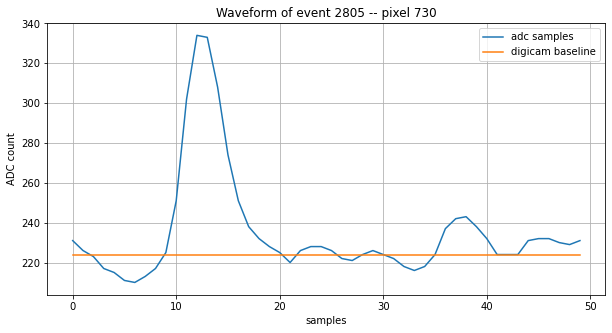

In [29]:
SAMPLES_IDS = np.arange(50)
ADC_SAMPLES = r0data.adc_samples[PIXEL_ID]
DIGICAM_BASELINE = np.ones(50)*r0data.digicam_baseline[PIXEL_ID]

f,ax = plt.subplots(figsize=(10,5))
p = ax.plot(SAMPLES_IDS,ADC_SAMPLES, label='adc samples')
p = ax.plot(SAMPLES_IDS,DIGICAM_BASELINE, label='digicam baseline')

ax.legend()
ax.grid()
ax.set_title('Waveform of event {} -- pixel {}'.format(EVENT,PIXEL_ID))
ax.set_xlabel('samples')
ax.set_ylabel('ADC count')

Text(0, 0.5, 'ADC count')

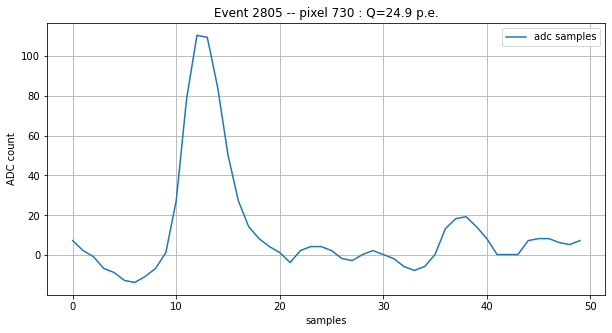

In [15]:
GAIN = 23  ## ADC/p.e.
SAMPLES_IDS = np.arange(50)
ADC_SAMPLES = r0data.adc_samples[PIXEL_ID] - r0data.digicam_baseline[PIXEL_ID]

CHARGE = ADC_SAMPLES.sum()/GAIN

f,ax = plt.subplots(figsize=(10,5))
p = ax.plot(SAMPLES_IDS,ADC_SAMPLES, label='adc samples')
ax.legend()
ax.grid()
ax.set_title('Event {} -- pixel {} : Q={:.3} p.e.'.format(EVENT,PIXEL_ID,CHARGE))
ax.set_xlabel('samples')
ax.set_ylabel('ADC count')

In [16]:
## get the Charge for all pixels
wfs = (r0data.adc_samples.T - r0data.digicam_baseline).T
Qsum = (r0data.adc_samples.T - r0data.digicam_baseline).sum(axis=0)/GAIN
        

Text(0.5, 1.0, 'raw image')

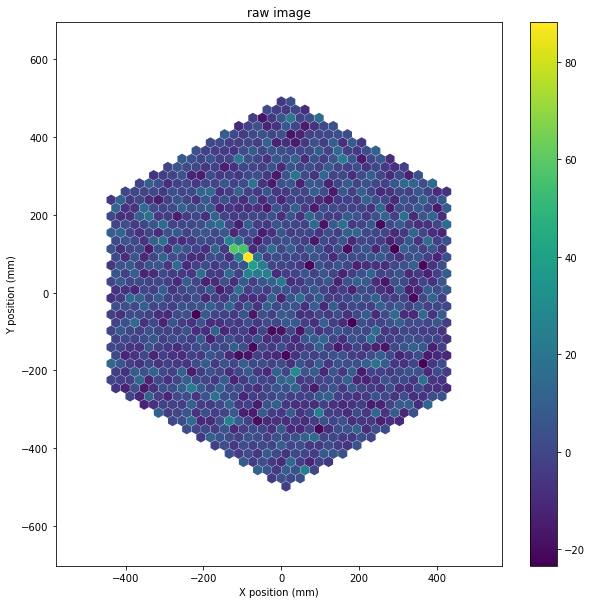

In [17]:
f,ax = plt.subplots(figsize=(10,10))
disp = CameraDisplay(geom,ax=ax)
disp.add_colorbar(ax=ax)
disp.image = Qsum
ax.set_title("raw image")

In [18]:
mask = tailcuts_clean(geom            = geom, 
                      image           = Qsum,
                      picture_thresh  = 10,
                      boundary_thresh = 7,
                      min_number_picture_neighbors=3)

In [19]:
n_island,mask_island = number_of_islands(geom, mask)
n_island

2

Text(0.5, 1.0, 'cleaned image (1st path)')

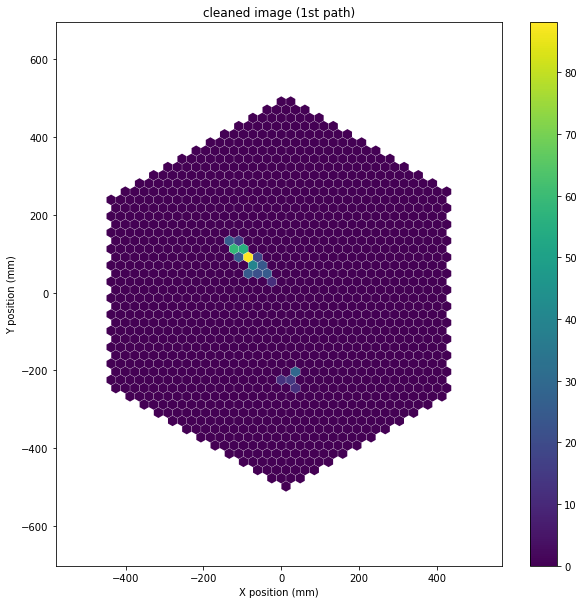

In [20]:
image = Qsum.copy()
image[~mask]= 0

f,ax = plt.subplots(figsize=(10,10))
disp = CameraDisplay(geom,ax=ax)
disp.add_colorbar(ax=ax)
disp.image = image
ax.set_title("cleaned image (1st path)")

In [21]:
## keep brigthest island
islandQs = []
for jj in range(n_island):
    islandQs.append(Qsum[mask_island == jj+1 ].sum())
islandQs = np.array(islandQs)
mask_1island = (mask_island == np.argmax(islandQs)+1)

In [22]:
mask_1island_2= dilate(geom,mask_1island) ## adding neneighbors pixel

cleaned_image = Qsum.copy()
cleaned_image[~mask_1island_2] = 0

## second tailcuts with lighter threshold
final_mask = tailcuts_clean(geom            = geom,   
                            image           = cleaned_image,
                            picture_thresh  = 5,
                            boundary_thresh = 3,
                            min_number_picture_neighbors=2)
            

Text(0.5, 1.0, 'cleaned image (486.7 p.e.)')

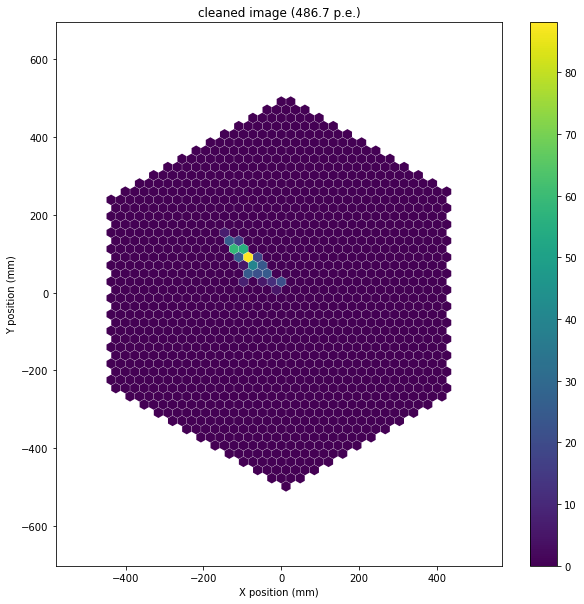

In [32]:
cleaned_image = Qsum.copy()
cleaned_image[~final_mask] =0

f,ax = plt.subplots(figsize=(10,10))
disp = CameraDisplay(geom,ax=ax)
disp.add_colorbar(ax=ax)
disp.image = cleaned_image
ax.set_title("cleaned image ({:.4} p.e.)".format(cleaned_image.sum()))

Text(0.5, 1.0, "event's waveforms")

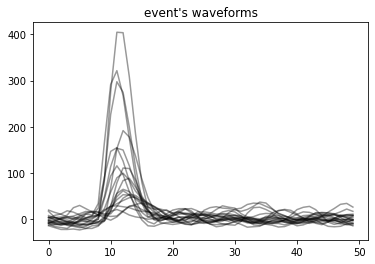

In [24]:
p = plt.plot(wfs[final_mask].T,color='black',alpha=.4)
plt.gca().set_title("event's waveforms")

Text(0.5, 1.0, 'hillas ellipse')

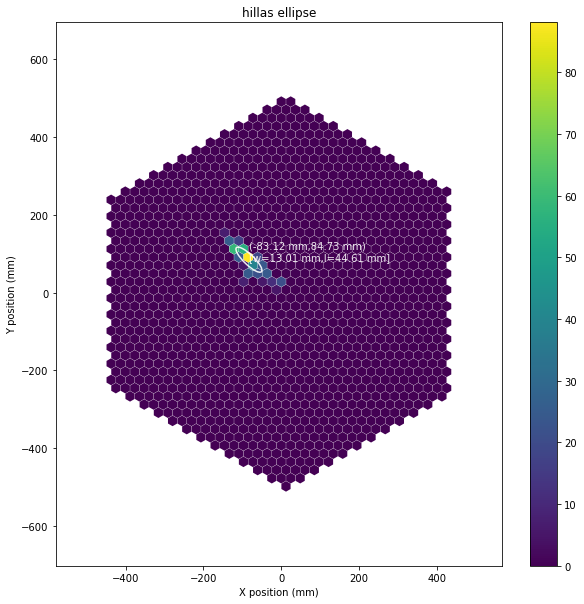

In [25]:
#hillas parametrisatiuon
hillas = hillas_parameters(geom, cleaned_image)

f,ax = plt.subplots(figsize=(10,10))
disp = CameraDisplay(geom,ax=ax)
disp.add_colorbar(ax=ax)
disp.image = cleaned_image
disp.overlay_moments(hillas, color='white', linewidth=1.5,zorder=300,alpha=.9)
ax.set_title("hillas ellipse")

In [26]:
hillas

ctapipe.io.containers.HillasParametersContainer:
                     intensity: total intensity (size)
                             x: centroid x coordinate
                             y: centroid x coordinate
                             r: radial coordinate of centroid
                           phi: polar coordinate of centroid [deg]
                        length: RMS spread along the major-axis
                         width: RMS spread along the minor-axis
                           psi: rotation angle of ellipse [deg]
                      skewness: measure of the asymmetry
                      kurtosis: measure of the tailedness

In [33]:
hillas.as_dict()

{'intensity': 486.70108695652175,
 'x': <Quantity -83.11678336 mm>,
 'y': <Quantity 84.73061371 mm>,
 'r': <Quantity 118.69151855 mm>,
 'phi': <Angle 2.34657992 rad>,
 'length': <Quantity 44.61452552 mm>,
 'width': <Quantity 13.00593609 mm>,
 'psi': <Angle 2.3771172 rad>,
 'skewness': -0.40074681734783074,
 'kurtosis': 2.7084160610770454}